## Bibliotecas

In [1]:
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

from nltk.corpus import stopwords
from collections import Counter
import pandas as pd
import numpy as np
import math
import operator
from functools import reduce
from matplotlib import pyplot as plt

## Consulta do Usuário

In [2]:
def ConsultaUsuário(consulta):
    
    My_stopwords = set(stopwords.words('english'))
    
    # Separar a consulta por palavras.
    palavras = word_tokenize(consulta)
    # Remover as Stopwords.
    lista_Termos = [i for i in palavras if i not in My_stopwords]
    
    
    #Remover Duplicatas
    #lista_Termos = list(dict.fromkeys(lista_Termos))
    #print(lista_Termos)
    
    # Stemming para pegar termos similares atraves dos radicais das palavras.
    ps = PorterStemmer()
    lista_radicais = []
    for w in lista_Termos:
        if ps.stem(w) not in lista_radicais: 
            lista_radicais.append(ps.stem(w))

    return lista_Termos

In [3]:
display(ConsultaUsuário('Blue Blue'))
display(ConsultaUsuário('Black Dragon'))

['Blue', 'Blue']

['Black', 'Dragon']

# Exemplos de Teste
* Modelo do Indice Invertido [ Termo , [ ( DOCUMENTO , TF/IDF ) ] ]
* Modelo da Consulta do Usuário: Texto qualquer

In [4]:
Docs = [
    ['Black',[('doc1',1),('doc2',2)]],
    ['dragon',[('doc2',3),('doc3',1)]],
    ['Illusion',[('doc4',1)]],
    ['lord',[('doc5',4)]]
]

consulta = r'Black Lotus of a Illusion'

## Postings
* Document at time
* term at time

## Modelo Espaço Vetorial

### Similaridade Cosseno de Vetores

In [5]:
# Similaridade Cosseno
def SimilaridadeCosseno(vetorQuery,vetorDoc):
    score = np.dot(vetorQuery,vetorDoc) / (math.sqrt((np.dot(vetorQuery,vetorQuery))*(np.dot(vetorDoc,vetorDoc))))
    return score

### Matrix de Vetores
* <strong>Sem TF/IDF</strong> 
    Apenas a presença do termo no documento.

In [6]:
def MatrixVetores(Postings,query):
    
    # Lista com os termos tanto dos postings quanto da consulta.
    termosVocabulario = []
    
    # Add consulta(query) e os documentos.
    documentoNomes = [query]
    
    # Add termos da consulta ao vocabulario.
    for termos in ConsultaUsuário(query):
        if termos not in termosVocabulario:
            termosVocabulario.append(termos)
    
    # Add os termos dos documentos dos postings ao vocabulario.
    for posting in Postings:
        if posting[0] not in termosVocabulario:
            termosVocabulario.append(posting[0])
        for tupla in posting[1]:
            if tupla[0] not in documentoNomes:
                documentoNomes.append(tupla[0])
    
    #print('termos do Vocabulario (Query e Documentos): ',termosVocabulario,"\n\n")
    #print('Nome dos Documentos (Query e Documentos): ',documentoNomes,"\n\n")
    
    # Criando matrix de vetores 
    matrixVazia = np.zeros((len(termosVocabulario),len(documentoNomes)),dtype=object)
    
    # Add nomes as rows e columns (rows = termos e columns docs)
    df = pd.DataFrame(matrixVazia, columns=documentoNomes, index=termosVocabulario)
    
    # Inserir os valores na matrix (sem tf/idf) se existe 1 se não 0
    nameColumns = list(df.columns)
    nameRows = list(df.index)
     
    # Preenchendo os valores dos vetores usando Document-at-time.
    for doc in nameColumns:
        for termo in nameRows:
            
            # Verificando a query.
            if termo in ConsultaUsuário(query) and doc == query:
                df.loc[termo,doc] = 1
            else:
                df.loc[termo,doc] = 0
     
            # Verificando os docs.
            for posting in Postings:
                if termo == posting[0]:
                    for tupla in posting[1]:
                        if doc == tupla[0]:
                            if tupla[1] > 0:
                                df.loc[termo,doc] = 1
                            else:
                                df.loc[termo,doc] = 0
      
    
    df.rename(columns={query:'Query'},inplace = True)    
    #display(df)
    return df
print('Exemplo: consulta = Black Lotus of a Illusion')
MatrixVetores(Docs,consulta)

Exemplo: consulta = Black Lotus of a Illusion


,Query,doc1,doc2,doc3,doc4,doc5
Black,1,1,1,0,0,0
Lotus,1,0,0,0,0,0
Illusion,1,0,0,0,1,0
dragon,0,0,1,1,0,0
lord,0,0,0,0,0,1


### Matrix de Vetores
* <strong>TF/IDF</strong> 

In [7]:
def MatrixVetores_TF_IDF(Postings,query):
    
    # Lista com os termos tanto dos postings quanto da consulta.
    termosVocabulario = []
    
    # Add consulta(query) e os documentos.
    documentoNomes = [query]
    
    # Add termos da consulta ao vocabulario.
    for termos in ConsultaUsuário(query):
        if termos not in termosVocabulario:
            termosVocabulario.append(termos)
    
    # Add os termos dos documentos dos postings ao vocabulario.
    for posting in Postings:
        if posting[0] not in termosVocabulario:
            termosVocabulario.append(posting[0])
        for tupla in posting[1]:
            if tupla[0] not in documentoNomes:
                documentoNomes.append(tupla[0])
    
    #print('termos do Vocabulario (Query e Documentos): ',termosVocabulario,"\n\n")
    #print('Nome dos Documentos (Query e Documentos): ',documentoNomes,"\n\n")
    
    # Criando matrix de vetores 
    matrixVazia = np.zeros((len(termosVocabulario),len(documentoNomes)),dtype=object)
    
    # Add nomes as rows e columns (rows = termos e columns docs)
    df = pd.DataFrame(matrixVazia, columns=documentoNomes, index=termosVocabulario)
    
    # Inserir os valores na matrix (sem tf/idf) se existe 1 se não 0
    nameColumns = list(df.columns)
    nameRows = list(df.index)
     
    # Preenchendo os valores dos vetores.
    for doc in nameColumns:
        for termo in nameRows:
            
            # Verificando a query.
            if termo in ConsultaUsuário(query) and doc == query:                
                # por enquanto só TF
                TF = ConsultaUsuário(query).count(termo) #/len(ConsultaUsuário(query))
                df.loc[termo,doc] = TF
            else:
                df.loc[termo,doc] = 0
     
            # Verificando os docs.
            for posting in Postings:
                if termo == posting[0]:
                    for tupla in posting[1]:
                        if doc == tupla[0]:
                            if tupla[1] > 0:
                                # valor do 2 componente da tupla [termo , [ ( doc, TF/IDF ) ] ]
                                df.loc[termo,doc] = tupla[1]
                            else:
                                df.loc[termo,doc] = 0      
    
    df.rename(columns={query:'Query'},inplace = True)    
    #display(df)
    return df
print('Exemplo: consulta = Black Lotus of a Illusion')
MatrixVetores_TF_IDF(Docs,consulta)

Exemplo: consulta = Black Lotus of a Illusion


,Query,doc1,doc2,doc3,doc4,doc5
Black,1,1,2,0,0,0
Lotus,1,0,0,0,0,0
Illusion,1,0,0,0,1,0
dragon,0,0,3,1,0,0
lord,0,0,0,0,0,4


### Resposta Consulta 
    *Lista de Documentos Ordenada pela similaridade dos cossenos (Documento e Query)

In [8]:
# Resposta
def RespostaConsulta(matrixVetores):
    
    # Lista de cocumentos e seus scores (doc,score)
    ListaDocumentos = []
    
    # Pegando o vetorQuery
    vetorQuery = matrixVetores['Query'].to_numpy()
    
    for col in matrixVetores.columns:  
        # Score da Similaridade de cossenos
        score = SimilaridadeCosseno(vetorQuery,matrixVetores[col].to_numpy())
        
        # documento comparado a query
        documento = col

        ListaDocumentos.append((documento,score))
    
    # Ordenar pelo Score.
    ListaDocumentos.sort(key=operator.itemgetter(1),reverse=True)
    
    return ListaDocumentos

## Resposta usando MatrixVetores sem TF/IDF

In [9]:
print('Exemplo: consulta = Black Lotus of a Illusion')
RespostaConsulta(MatrixVetores(Docs,consulta))

Exemplo: consulta = Black Lotus of a Illusion


[('Query', 1.0),
 ('doc1', 0.5773502691896258),
 ('doc4', 0.5773502691896258),
 ('doc2', 0.4082482904638631),
 ('doc3', 0.0),
 ('doc5', 0.0)]

In [10]:
print('Exemplo: consulta = Blue and Red dragon')
RespostaConsulta(MatrixVetores(Docs,'Blue and Red dragon'))

Exemplo: consulta = Blue and Red dragon


[('Query', 1.0),
 ('doc3', 0.5773502691896258),
 ('doc2', 0.4082482904638631),
 ('doc1', 0.0),
 ('doc4', 0.0),
 ('doc5', 0.0)]

## Resposta usando MatrixVetores com TF/IDF

In [11]:
print('Exemplo: consulta = Black Lotus of a Illusion')
RespostaConsulta(MatrixVetores_TF_IDF(Docs,consulta))

Exemplo: consulta = Black Lotus of a Illusion


[('Query', 1.0),
 ('doc1', 0.5773502691896258),
 ('doc4', 0.5773502691896258),
 ('doc2', 0.32025630761017426),
 ('doc3', 0.0),
 ('doc5', 0.0)]

In [12]:
print('Exemplo: consulta = Blue and Red dragon')
RespostaConsulta(MatrixVetores_TF_IDF(Docs,'Blue and Red dragon'))

Exemplo: consulta = Blue and Red dragon


[('Query', 1.0),
 ('doc3', 0.5773502691896258),
 ('doc2', 0.48038446141526137),
 ('doc1', 0.0),
 ('doc4', 0.0),
 ('doc5', 0.0)]

# Correlação de Spearman

In [13]:
# Correlação de Spearman
def Correlação_Spearman(consultasRepostas):
    
    # Removendo indice de query
    for listaconsulta in consultasRepostas:
        for tupla in listaconsulta:
            if tupla[0] == 'Query':
                listaconsulta.remove(tupla)
    
    # tamanho da matrix
    numeroColunas = len(consultasRepostas[0])
    numeroLinhas = len(consultasRepostas)
    
    colunaNomes = []
    linhaNomes = []
    dicionariolinhas = {}
    count = 0
    # Definindo os nomes da matrix
    for lista in consultasRepostas:
        # Nomes das colunas
        for tupla in lista:
            if tupla[0] not in colunaNomes:
                colunaNomes.append(tupla[0])
        
        # Nome das linhas
        count = count + 1
        nomelista = 'Consulta ' + str(count)
        linhaNomes.append(nomelista)
        dicionariolinhas[nomelista] = lista
    
    # matrixVazia
    matrixVazia = np.zeros((numeroLinhas,numeroColunas),dtype=object)
    # Add nomes as rows e columns
    df = pd.DataFrame(matrixVazia, columns=colunaNomes, index=linhaNomes)
    
    matrixColunas = list(df.columns)
    matrixLinhas = list(df.index)
     
    # Preenchendo os valores dos vetores.
    for linha in matrixLinhas: 
        for coluna in matrixColunas: 
            
            for lista in consultasRepostas:
                if dicionariolinhas[linha] == lista:
                    for tupla in lista:
                        if coluna == tupla[0]:
                            df.loc[linha,coluna] = tupla[1]
                            
    
    # Calculando os rankings
    dicionarioRankings = {}  
    for linha in matrixLinhas:

        auxDF = df.copy()
        
        listatuplas = []
        countMax = 1
        countMin = len(auxDF.columns)
        
        for coluna in matrixColunas:
            
            if auxDF.loc[linha,coluna] == auxDF.loc[linha].max():
                
                Ranking = countMax
                if(coluna,Ranking) not in listatuplas:
                    listatuplas.append((coluna,Ranking))
                    
                dicionarioRankings[linha] = listatuplas
                countMax = countMax + 1
                
            elif auxDF.loc[linha,coluna] == auxDF.loc[linha].min():
                
                Ranking = countMin
                if(coluna,Ranking) not in listatuplas:
                    listatuplas.append((coluna,Ranking))
                    
                dicionarioRankings[linha] = listatuplas
                countMin = countMin - 1
            else:
                Ranking = countMin-1
                if(coluna,Ranking) not in listatuplas:
                    listatuplas.append((coluna,Ranking))
                    
                dicionarioRankings[linha] = listatuplas                
                continue
            
            auxDF.drop(coluna,axis=1,inplace=True)
    
    print('Consultas e seus Rankings ',dicionarioRankings,'\n')
    
    # diferença dos rankings
    diferencaRankings = []
    listaDicionariosRankings = []
    for linha in matrixLinhas:
        listaDicionariosRankings.append(dict(dicionarioRankings[linha]))
    
    print('Rankings por consulta(dict = consulta): ',listaDicionariosRankings,'\n')
    
    # Rankings
    Rankings = []
    for elem in listaDicionariosRankings:
        h = list(elem.values())
        Rankings.append(h)
    print('Rankings: ', Rankings,'\n')
    
    # Diferença entre os Rankings
    for nome in colunaNomes:
        t = [d[nome] for d in listaDicionariosRankings if nome in d]
        diferencaRankings.append(reduce(operator.sub, t))

    print('Diferença entre os Rankings: ',diferencaRankings , '\n')
    
    # Quadrado da diferença entre os Rankings
    diferencaRankingsQuadrado = [i ** 2 for i in diferencaRankings]
    print('Quadrado da diferença entre os Rankings: ',diferencaRankingsQuadrado,'\n')
    
    # Somatorio dos quadrados da diferença
    somatorio = sum(diferencaRankingsQuadrado)
    print('Somatorio: ', somatorio , '\n')
    
    n = len(diferencaRankingsQuadrado)
    
    # Coeficiente spearman
    cs = 1 - ((6*somatorio) / (n * ((n**2) - 1)))  
    print('Coeficiente de Spearman: ',cs)
    
    ###################################GRafico####################################################################
    
    x = Rankings[0]
    y = Rankings[1]
    plt.scatter(x,y, label= "Pontos", color= "black",s=50)
    # naming the x axis 
    plt.xlabel('Ranking 1 | Consulta 1') 
    # naming the y axis 
    plt.ylabel('Ranking 2 | Consulta 2')
    plt.title('Correlação de Spearman') 
    # showing legend 
    plt.legend() 

    axes = plt.gca()
    m, b = np.polyfit(x, y, 1)
    X_plot = np.linspace(axes.get_xlim()[0],axes.get_xlim()[1],100)
    plt.plot(X_plot, m*X_plot + b, '-')
    
    
    return plt.show()

## Coeficiente da Correlação de Spearman 
* consulta -> <strong>Black Lotus of a Illusion</strong>
* consulta -> <strong>Test a Illusion of a black dragon lord</strong>

Consultas e seus Rankings  {'Consulta 1': [('doc1', 1), ('doc4', 2), ('doc2', 3), ('doc3', 4), ('doc5', 5)], 'Consulta 2': [('doc1', 5), ('doc4', 1), ('doc2', 4), ('doc3', 2), ('doc5', 3)]} 

Rankings por consulta(dict = consulta):  [{'doc1': 1, 'doc4': 2, 'doc2': 3, 'doc3': 4, 'doc5': 5}, {'doc1': 5, 'doc4': 1, 'doc2': 4, 'doc3': 2, 'doc5': 3}] 

Rankings:  [[1, 2, 3, 4, 5], [5, 1, 4, 2, 3]] 

Diferença entre os Rankings:  [-4, 1, -1, 2, 2] 

Quadrado da diferença entre os Rankings:  [16, 1, 1, 4, 4] 

Somatorio:  26 

Coeficiente de Spearman:  -0.30000000000000004


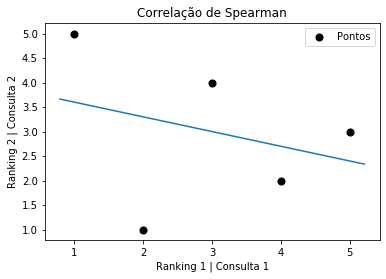

In [14]:
listadeRespostasConsulta  = [RespostaConsulta(MatrixVetores(Docs,consulta)),
                            RespostaConsulta(MatrixVetores(Docs,'Test a Illusion of a black dragon lord'))]
Correlação_Spearman(listadeRespostasConsulta)

# Testando Correlação de Spearman
* consulta 1 = <strong>Black Lotus of a Illusion</strong>
* consulta 2 = <strong>Test a Illusion of a black dragon lord</strong>
* consulta 3 = <strong>lord dragon</strong>
* consulta 4 = <strong>Red dragon</strong>
* consulta 5 = <strong>Illusion of a black lord</strong>

### consulta 1 e 2

Consultas e seus Rankings  {'Consulta 1': [('doc1', 1), ('doc4', 2), ('doc2', 3), ('doc3', 4), ('doc5', 5)], 'Consulta 2': [('doc1', 5), ('doc4', 1), ('doc2', 4), ('doc3', 2), ('doc5', 3)]} 

Rankings por consulta(dict = consulta):  [{'doc1': 1, 'doc4': 2, 'doc2': 3, 'doc3': 4, 'doc5': 5}, {'doc1': 5, 'doc4': 1, 'doc2': 4, 'doc3': 2, 'doc5': 3}] 

Rankings:  [[1, 2, 3, 4, 5], [5, 1, 4, 2, 3]] 

Diferença entre os Rankings:  [-4, 1, -1, 2, 2] 

Quadrado da diferença entre os Rankings:  [16, 1, 1, 4, 4] 

Somatorio:  26 

Coeficiente de Spearman:  -0.30000000000000004


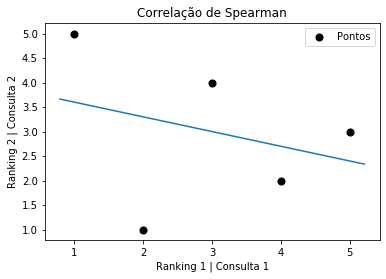

In [15]:
listadeRespostasConsulta  = [RespostaConsulta(MatrixVetores(Docs,consulta)),
                            RespostaConsulta(MatrixVetores(Docs,'Test a Illusion of a black dragon lord'))]
Correlação_Spearman(listadeRespostasConsulta)

### consulta 1 e 3

Consultas e seus Rankings  {'Consulta 1': [('doc1', 1), ('doc4', 2), ('doc2', 3), ('doc3', 4), ('doc5', 5)], 'Consulta 2': [('doc1', 5), ('doc4', 4), ('doc2', 3), ('doc3', 1), ('doc5', 2)]} 

Rankings por consulta(dict = consulta):  [{'doc1': 1, 'doc4': 2, 'doc2': 3, 'doc3': 4, 'doc5': 5}, {'doc1': 5, 'doc4': 4, 'doc2': 3, 'doc3': 1, 'doc5': 2}] 

Rankings:  [[1, 2, 3, 4, 5], [5, 4, 3, 1, 2]] 

Diferença entre os Rankings:  [-4, -2, 0, 3, 3] 

Quadrado da diferença entre os Rankings:  [16, 4, 0, 9, 9] 

Somatorio:  38 

Coeficiente de Spearman:  -0.8999999999999999


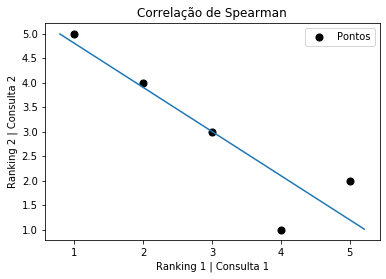

In [16]:
listadeRespostasConsulta  = [RespostaConsulta(MatrixVetores(Docs,consulta)),
                            RespostaConsulta(MatrixVetores(Docs,'lord dragon'))]
Correlação_Spearman(listadeRespostasConsulta)

### consulta 1 e 4

Consultas e seus Rankings  {'Consulta 1': [('doc1', 1), ('doc4', 2), ('doc2', 3), ('doc3', 4), ('doc5', 5)], 'Consulta 2': [('doc1', 5), ('doc4', 4), ('doc2', 2), ('doc3', 1), ('doc5', 3)]} 

Rankings por consulta(dict = consulta):  [{'doc1': 1, 'doc4': 2, 'doc2': 3, 'doc3': 4, 'doc5': 5}, {'doc1': 5, 'doc4': 4, 'doc2': 2, 'doc3': 1, 'doc5': 3}] 

Rankings:  [[1, 2, 3, 4, 5], [5, 4, 2, 1, 3]] 

Diferença entre os Rankings:  [-4, -2, 1, 3, 2] 

Quadrado da diferença entre os Rankings:  [16, 4, 1, 9, 4] 

Somatorio:  34 

Coeficiente de Spearman:  -0.7


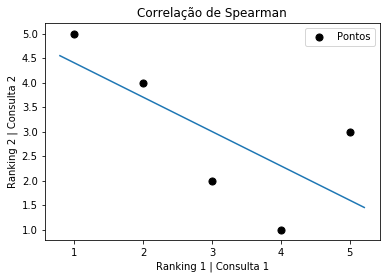

In [17]:
listadeRespostasConsulta  = [RespostaConsulta(MatrixVetores(Docs,consulta)),
                            RespostaConsulta(MatrixVetores(Docs,'Red dragon'))]
Correlação_Spearman(listadeRespostasConsulta)

### consulta 1 e 5

Consultas e seus Rankings  {'Consulta 1': [('doc1', 1), ('doc4', 2), ('doc2', 3), ('doc3', 4), ('doc5', 5)], 'Consulta 2': [('doc1', 5), ('doc4', 1), ('doc2', 4), ('doc3', 3), ('doc5', 2)]} 

Rankings por consulta(dict = consulta):  [{'doc1': 1, 'doc4': 2, 'doc2': 3, 'doc3': 4, 'doc5': 5}, {'doc1': 5, 'doc4': 1, 'doc2': 4, 'doc3': 3, 'doc5': 2}] 

Rankings:  [[1, 2, 3, 4, 5], [5, 1, 4, 3, 2]] 

Diferença entre os Rankings:  [-4, 1, -1, 1, 3] 

Quadrado da diferença entre os Rankings:  [16, 1, 1, 1, 9] 

Somatorio:  28 

Coeficiente de Spearman:  -0.3999999999999999


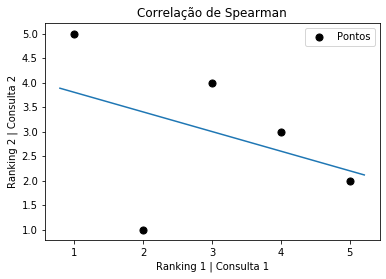

In [18]:
listadeRespostasConsulta  = [RespostaConsulta(MatrixVetores(Docs,consulta)),
                            RespostaConsulta(MatrixVetores(Docs,'Illusion of a black lord'))]
Correlação_Spearman(listadeRespostasConsulta)